In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import repeat


from snewpy import snowglobes
from astropy import units as u
from snewpy.neutrino import Flavor, MassHierarchy, MixingParameters
from snewpy.models.ccsn import *
from snewpy.flavor_transformation import AdiabaticMSW


SNOwGLoBES_path = "/Users/sierra/Desktop/neutrino_fall_2022/dependencies/snowglobes"
SNEWPY_models_base = "/Users/sierra/Desktop/neutrino_fall_2022/dependencies/SNEWPY_models"  # directory containing SNEWPY models

# set parameters that don't vary over all models
# set distance in kpc
distance = 1.0

# set SNOwGLoBES detector to use
detector = "ar40kt"

# set desired flavor transformation
transformation = 'AdiabaticMSW_NMO'

window_tstart = 0.1015 # Fornax adjusted time bins
window_tend = 4.1015
window_bins = 800 # .005 s time bin

window_tstart_burst = -0.0505 # Fornax adjusted time bins
window_tend_burst = 0.1015
window_bins_burst = 76 # .002 s time bin


tstart = np.linspace(window_tstart, window_tend, window_bins, endpoint=False) 
tend = tstart + (window_tend - window_tstart) / window_bins 
tmid = (tstart + tend) * 0.5 

tstart_burst = np.linspace(window_tstart_burst, window_tend_burst, window_bins_burst, endpoint=False) 
tend_burst = tstart_burst + (window_tend_burst - window_tstart_burst) / window_bins_burst 
tmid_burst = (tstart_burst + tend_burst) * 0.5 

tstart = np.append(tstart_burst, tstart)
tend = np.append(tend_burst, tend)

# rename factor
change_to_s = window_bins / (window_tend - window_tstart) / 1000
change_to_s_burst = window_bins_burst / (window_tend_burst - window_tstart_burst) / 1000

# number of lines in dat file
num_lines = 200

extended_time = [x for item in tstart for x in repeat(item, num_lines)]
extended_time = np.array_split(extended_time, window_bins + window_bins_burst)

plt.rcParams.update({'font.size': 18})


In [2]:
# make new colorbar

# opening the file in read mode
new_colorbar = open("/Users/sierra/Desktop/neutrino/colormap_updated.txt", "r")
  
# reading the file
data = new_colorbar.read()
  
# replacing end splitting the text 
# when newline ('\n') is seen.
c = data.split('\n')

new_colorbar.close()

cm_u = mpl.colors.ListedColormap(c)

In [7]:
def get_interaction_arrays(energy_inst, interaction_inst, summed_data, channel, file_directory):
    channel_type = summed_data
    sorted_dir = os.listdir(file_directory)
    sorted_dir = sorted(sorted_dir, key=lambda x:float(re.findall("(\d+)", x)[-2]))
    # get all unsmeared files - need underscore, otherwise code will get confused
    interaction_type_lst = [s for s in sorted_dir if "_unsmeared" in s]
    # get all unweighted files - need underscore, otherwise code will get confused
    interaction_type_lst = [s for s in interaction_type_lst if "_unweighted" in s]
    for filename in interaction_type_lst:
        #print(filename)
        with open(os.path.join(file_directory, filename), 'r') as f:
            interaction_sum = 0
            next(f)
            next(f) # skip string headers
            if channel == "nue_Ar40":
                for line in f:
                    energy_inst.append(float(line.split()[0]))
                    interaction_inst.append(float(line.split()[1]))
                    interaction_sum += float(line.split()[1])
                channel_type.append(interaction_sum)
                interaction_sum = 0
            if channel == "nuebar_Ar40":
                for line in f:
                    energy_inst.append(float(line.split()[0]))
                    interaction_inst.append(float(line.split()[2]))
                    interaction_sum += float(line.split()[2])
                channel_type.append(interaction_sum)
                interaction_sum = 0
            if channel == "nc":
                for line in f:
                    energy_inst.append(float(line.split()[0]))
                    interaction_inst.append(float(line.split()[3]))
                    interaction_sum += float(line.split()[3])
                channel_type.append(interaction_sum)
                interaction_sum = 0
            if channel == "e":
                for line in f:
                    energy_inst.append(float(line.split()[0]))
                    interaction_inst.append(float(line.split()[4]))
                    interaction_sum += float(line.split()[4])
                channel_type.append(interaction_sum)
                interaction_sum = 0
            if channel == "cc":
                for line in f:
                    energy_inst.append(float(line.split()[0]))
                    interaction_inst.append(float(line.split()[1]) + float(line.split()[2]))
                    interaction_sum += float(line.split()[1]) + float(line.split()[2])
                channel_type.append(interaction_sum)
                interaction_sum = 0
            if channel == "all":
                for line in f:
                    zero += float(line.split()[0])
                    one += float(line.split()[1])
                    two += float(line.split()[2])
                    three += float(line.split()[3])
                    four += float(line.split()[4])
                    five += float(line.split()[5])
                    energy_inst.append(float(line.split()[0]))
                    interaction_inst.append(float(line.split()[1]) + float(line.split()[2]) + float(line.split()[3]) + float(line.split()[4]) + float(line.split()[5]))
                    interaction_sum += float(line.split()[1]) + float(line.split()[2]) + float(line.split()[3]) + float(line.split()[4]) + float(line.split()[5])
                channel_type.append(interaction_sum)
                
                interaction_sum = 0
                print("column 0", zero)
                print("column 1", one)
                print("column 2", two)
                print("column 3", three)
                print("column 4", four)
                print("column 5", five)
                print("sum of columns (except energy) is", one + two + three+ four + five)
    return channel_type
                

In [8]:
def sort_by_phase(tstart, window_tend_burst):
    high_res = []
    for i in tstart:
        if i <= window_tend_burst:
            high_res.append(i)
    
    burst, cooling = [], []
    for i in (tstart):
        if i <= 0.06:
            burst.append(i)
        #if i > 0.1 and i <= 0.5:
        #    accretion.append(i)
        if i > 0.06: #.5
            cooling.append(i)
    return burst, cooling, high_res


def extend_phase(burst, cooling):
    ext_burst = [x for item in burst for x in repeat(item, num_lines)]
    ext_burst = np.array_split(ext_burst,len(burst))

    ext_cooling = [x for item in cooling for x in repeat(item, num_lines)]
    ext_cooling = np.array_split(ext_cooling,len(cooling))
    
    return ext_burst, ext_cooling

def shape_and_scale_interaction(inst_interaction, energy, high_res):
    l = np.array_split(inst_interaction, window_bins + window_bins_burst)
    l = [value * (1/4) for value in l] # 10 kt detector, scales linearly
    e = np.array_split(energy, window_bins + window_bins_burst)
    e = [value * 1000 for value in e] #get to MeV
    
    return l, e

def scale_interaction(l, high_res):
    #print(high_res)
    #l = [value * change_to_s_burst for value in l[:len(high_res) -1]] + [value * change_to_s for value in l[len(high_res) -1 :]]
    list1 = [value * (1/4) for value in l] # 10 kt detector, scales linearly
    return list1
    
    
def scale_detector(l, high_res):
    #print(high_res)
    #l = [value * factor_to_rescale_burst for value in l[:len(high_res) -1]] + [value * factor_to_rescale for value in l[len(high_res) -1:]]
    list1 = [value * (1/4) for value in l] # 10 kt detector, scales linearly
    return list1

def scale_detector_res(l, burst, change_to_s_burst, change_to_s):
    list1 = [value * change_to_s_burst for value in l[:len(burst) -1]] 
    list2 = [value * change_to_s for value in l[len(burst) -1:]]
    list1.extend(list2)
    list3 = [value * (1/4) for value in list1] # 10 kt detector, scales linearly
    return list3
    
    
def formatted_flavor(interaction):
    if interaction == "nc":
        overleaf_interaction = "Neutral current"
    if interaction == "cc":
        overleaf_interaction = "Charged current"
    return overleaf_interaction

def plot_projected(channel_t, ax1, ax2, local_max_location, overleaf_flavor, burst):
    pcm1 = ax1.plot(tstart[:len(burst)], channel_t[local_max_location:local_max_location + len(burst)], label = overleaf_flavor)
    pcm2 = ax2.plot(tstart[len(burst):len(tstart) - local_max_location] * u.s, channel_t[len(burst) + local_max_location:], label = overleaf_flavor)

def divide_lists(list1, list2):
    new_list = [x / y for x, y in zip(list1, list2)]
    return new_list
def plot_blocks(channel_t, ax1, ax2, local_max_location, overleaf_flavor, burst, tstart):
    pcm1 = ax1.plot(tstart, channel_t, label = overleaf_flavor, alpha = .5, drawstyle = "steps-mid")
    pcm2 = ax2.plot(tstart[len(burst):len(tstart) - local_max_location] * u.s, channel_t[len(burst) + local_max_location:], label = overleaf_flavor, drawstyle = "steps-mid")    
    
def normalize_by_peak(test13, burst, relative_to):
    peak_first = np.max(relative_to[len(burst) -1:])
    peak_second = np.max(relative_to[len(burst):])
    list1 = [(value)/peak_first for value in test13[:len(burst) -1]] 
    list2 = [value/(10 * peak_first) for value in test13[len(burst) -1:]]
    list1.extend(list2)
    return list1

def normalize_by_avg(test13, burst, relative_to):
    i = 0
    while i < len(test13):
        if test13[i] > 180:
            value = i
            print(value)
            break 
        else:
            i += 1
    scale_value = (test13[value] + test13[value + 1])/2
    print(scale_value)

    list1 = [(value)/scale_value for value in test13[:len(burst) -1]] 
    list2 = [value/(scale_value * 10) for value in test13[len(burst) -1:]]
    list1.extend(list2)    
    print((list1[value] + list1[value + 1])/2)
    return list1

def inverse_normalize_by_peak(test13, burst, relative_to):
    peak_first = np.max(relative_to[:len(burst) -1])
    peak_second = np.max(relative_to[len(burst):])
    list1 = [(value)/peak_first for value in test13[:len(burst) -1]] 
    list2 = [value/( 10 * peak_first) for value in test13[len(burst) -1:]]
    list1.extend(list2)
    return list1

def scale(test13, burst, relative_to, scale_burst, scale_rest):
    peak_first = np.max(relative_to[len(burst):])
    peak_second = np.max(relative_to[len(burst):])
    list1 = [(value * scale_burst)/100 for value in test13[:len(burst) -1]] 
    list2 = [(value * scale_rest)/10 for value in test13[len(burst) -1:]]
    list1.extend(list2)
    return list1
def find_max(listy, high_res):
    return 1.1 * np.max(listy[len(high_res) -1:])

def plot_projected(adj, tstart, nue_test, ax1, ax2, local_max_location, overleaf_flavor, burst, cooling):
    total = len(tstart)
    ax1.plot(tstart[:len(burst) + adj] * u.s, nue_test[local_max_location:len(burst) + local_max_location + adj], label = overleaf_flavor, drawstyle='steps-mid')
    ax2.plot(tstart[len(burst) + adj -1:len(burst)+len(cooling) + adj -2] * u.s, nue_test[len(burst) + local_max_location -1 + adj:len(burst)+len(cooling) + local_max_location+ adj -2], label = overleaf_flavor, drawstyle='steps-mid')
    
def preserve_event_rates(test13, burst, relative_to):
    list1 = [value * (1/4) for value in test13[:len(burst) -1]] 
    list2 = [value/(4 * 10) for value in test13[len(burst) -1:]]
    list1.extend(list2)
    return list1


In [9]:
# can I make them the same per ms?

def get_and_plot_multiple_int_interactions(interaction, files, mass, model, msw, tstart, scale_burst, scale_rest):
    energy, channel_t, inst_interaction = [], [], []
    burst, cooling, high_res = [], [], []
    test13, test16, test17, test20, test27 = [], [], [], [], []
    
    local_max_location = 0
    overleaf_interaction = formatted_flavor(interaction)
    burst, cooling, high_res = sort_by_phase(tstart, window_tend_burst)    
    tstart = [x-.03 for x in tstart]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 5), tight_layout=True, gridspec_kw={'width_ratios': [1, 2]})
    
    
    get_interaction_arrays(energy, inst_interaction, test16, interaction, files)

    #test16 = scale(test16, high_res, test16, scale_burst, scale_rest)
    test16 = preserve_event_rates(test16, high_res, test16)
    plot_projected(4, tstart, test16, ax1, ax2, local_max_location, "interaction", burst, cooling)
    #plot_blocks(test16, ax1, ax2, local_max_location, "27M 2ms", burst, tstart)   
    

    ax1.set_xlabel("t[s]")
    ax1.set_ylabel(f"Events per 10 ms")
    ax1.set_ylim(0,find_max(test16, high_res))
    ax1.margins(0)

    #ax2.legend(prop={'size': 17})
    
    ax2.set_xlabel("t[s]")
    ax2.set_ylim(0,find_max(test16, high_res))
    #ax1.set_ylim(0,local_max)
    ax2.margins(0)
    ax2.set_yticks([])


    plt.suptitle(f'{overleaf_interaction} interactions (unsmeared) in a 10-kiloton liquid argon detector, from a {model} model of {mass} M☉ progenitor, 1kpc away - {msw} effects')
    #plt.suptitle(f'Smeared {overleaf_interaction} interactions in a 10-kiloton liquid argon detector, from a {model} model of {mass} M☉ progenitor, 1kpc away - {msw} effects')
    plt.savefig(f'{interaction}_{mass}_{model}_{msw}.png')
    plt.show()





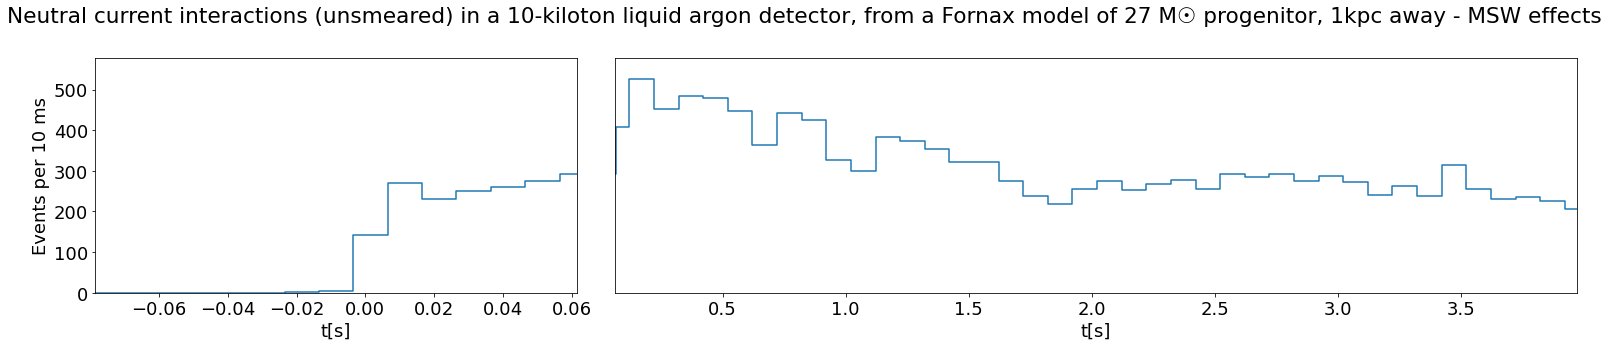

In [10]:
window_tstart = 0.1015 # Fornax adjusted time bins
window_tend = 4.1015
window_bins = 40 # .1 s time bin

window_tstart_burst = -0.0485 # Fornax adjusted time bins
window_tend_burst = 0.1015
window_bins_burst = 15 # .01 s time bin


tstart = np.linspace(window_tstart, window_tend, window_bins, endpoint=False) 
tend = tstart + (window_tend - window_tstart) / window_bins 
tmid = (tstart + tend) * 0.5 

tstart_burst = np.linspace(window_tstart_burst, window_tend_burst, window_bins_burst, endpoint=False) 
tend_burst = tstart_burst + (window_tend_burst - window_tstart_burst) / window_bins_burst 
tmid_burst = (tstart_burst + tend_burst) * 0.5 

tstart = np.append(tstart_burst, tstart)
tend = np.append(tend_burst, tend)

scale_rest = window_bins / (window_tend - window_tstart)
scale_burst = window_bins_burst / (window_tend_burst - window_tstart_burst)


my_files = "/Users/sierra/neutrino_work/fall_2022_snewpy_project/inter_runs/fornax_27M/Fornax_2021_lum_spec_26.99M_r10000_dat.h5_AdiabaticMSW_NMO_SNOprocessed"
get_and_plot_multiple_int_interactions("nc", my_files, "27", "Fornax", "MSW", tstart, scale_burst, scale_rest)


8
726.3046858408061
0.9999999999999999
8
799.9639034184269
1.0
8
808.0543501216091
0.9999999999999999
8
793.5554464407758
1.0
8
811.6961655609726
1.0


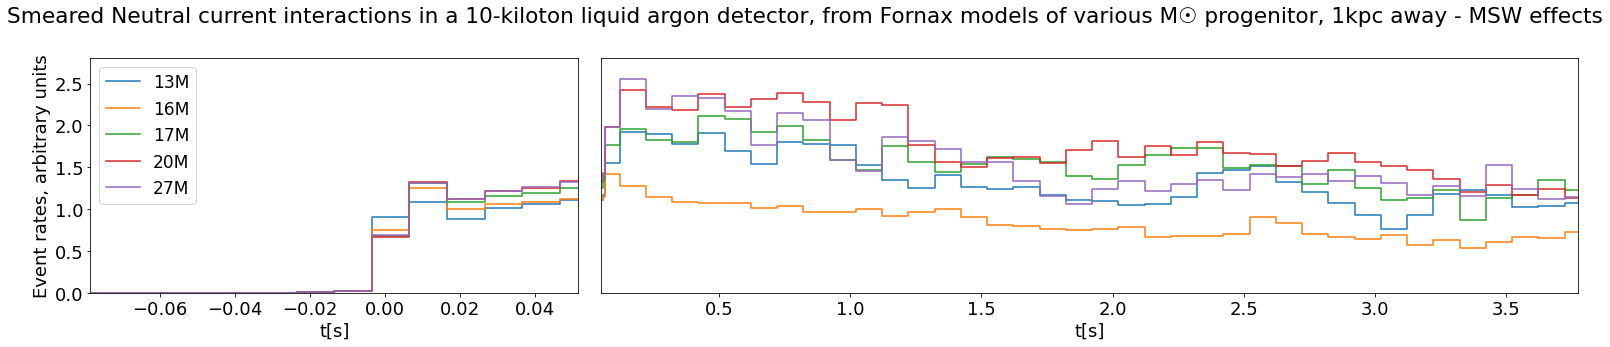

In [358]:
# can I make them the same per ms?

def get_and_plot_multiple_int_interactions(interaction, files, mass, model, msw, tstart, scale_burst, scale_rest):
    energy, channel_t, inst_interaction = [], [], []
    burst, cooling, high_res = [], [], []
    test13, test16, test17, test20, test27 = [], [], [], [], []
    
    local_max_location = 0
    overleaf_interaction = formatted_flavor(interaction)
    
    tstart = [x-.03 for x in tstart]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 5), tight_layout=True, gridspec_kw={'width_ratios': [1, 2]})
    


    files = "/Users/sierra/neutrino_work/fall_2022_snewpy_project/inter_runs/fornax_13M/Fornax_2021_lum_spec_13M_r10000_dat.h5_AdiabaticMSW_NMO_SNOprocessed"
    get_interaction_arrays(energy, inst_interaction, test13, interaction, files)
    burst, cooling, high_res = sort_by_phase(tstart, window_tend_burst)
    #test16 = scale(test16, high_res, test16, scale_burst, scale_rest)
    test13 = normalize_by_avg(test13, high_res, test13)
    plot_projected(0, tstart, test13, ax1, ax2, local_max_location, "13M", burst, cooling)
    
    
    files = "/Users/sierra/neutrino_work/fall_2022_snewpy_project/inter_runs/fornax_16M/Fornax_2021_lum_spec_16M_r10000_dat.h5_AdiabaticMSW_NMO_SNOprocessed"
    get_interaction_arrays(energy, inst_interaction, test16, interaction, files)
    #burst, cooling, high_res = sort_by_phase(tstart, window_tend_burst)
    #test16 = scale(test16, high_res, test16, scale_burst, scale_rest)
    test16 = normalize_by_avg(test16, high_res, test16)
    plot_projected(0, tstart, test16, ax1, ax2, local_max_location, "16M", burst, cooling)
    

    files = "/Users/sierra/neutrino_work/fall_2022_snewpy_project/inter_runs/fornax_17M/Fornax_2021_lum_spec_17M_r10000_dat.h5_AdiabaticMSW_NMO_SNOprocessed"
    get_interaction_arrays(energy, inst_interaction, test17, interaction, files)
    #burst, cooling, high_res = sort_by_phase(tstart, window_tend_burst)
    #test16 = scale(test16, high_res, test16, scale_burst, scale_rest)
    test17 = normalize_by_avg(test17, high_res, test17)
    plot_projected(0, tstart, test17, ax1, ax2, local_max_location, "17M", burst, cooling)
    #plot_blocks(test16, ax1, ax2, local_max_location, "27M 2ms", burst, tstart)       

    files = "/Users/sierra/neutrino_work/fall_2022_snewpy_project/inter_runs/fornax_20M/Fornax_2021_lum_spec_20M_r10000_dat.h5_AdiabaticMSW_NMO_SNOprocessed"
    get_interaction_arrays(energy, inst_interaction, test20, interaction, files)
    #burst, cooling, high_res = sort_by_phase(tstart, window_tend_burst)
    #test16 = scale(test16, high_res, test16, scale_burst, scale_rest)
    test20 = normalize_by_avg(test20, high_res, test20)
    plot_projected(0, tstart, test20, ax1, ax2, local_max_location, "20M", burst, cooling)
    #plot_blocks(test16, ax1, ax2, local_max_location, "27M 2ms", burst, tstart)        

    files = "/Users/sierra/neutrino_work/fall_2022_snewpy_project/inter_runs/fornax_27M/Fornax_2021_lum_spec_26.99M_r10000_dat.h5_AdiabaticMSW_NMO_SNOprocessed"
    get_interaction_arrays(energy, inst_interaction, test27, interaction, files)
    #burst, cooling, high_res = sort_by_phase(tstart, window_tend_burst)
    #test16 = scale(test16, high_res, test16, scale_burst, scale_rest)
    test27 = normalize_by_avg(test27, high_res, test27)
    plot_projected(0, tstart, test27, ax1, ax2, local_max_location, "27M", burst, cooling)
    #plot_blocks(test16, ax1, ax2, local_max_location, "27M 2ms", burst, tstart)       
    
    ax1.set_xlabel("t[s]")
    ax1.set_ylabel(f"Event rates, arbitrary units")
    #ax1.set_ylim(0,1.1)
    ax1.margins(0)

    ax1.legend(prop={'size': 17})
    
    ax2.set_xlabel("t[s]")
    #ax2.set_ylim(0,1.1)
    ax1.set_ylim(0,find_max(test27, high_res))
    ax2.set_ylim(0,find_max(test27, high_res))
    ax2.margins(0)
    ax2.set_yticks([])


    plt.suptitle(f'Smeared {overleaf_interaction} interactions in a 10-kiloton liquid argon detector, from {model} models of various M☉ progenitor, 1kpc away - {msw} effects')
    #plt.suptitle(f'Smeared {overleaf_interaction} interactions in a 10-kiloton liquid argon detector, from a {model} model of {mass} M☉ progenitor, 1kpc away - {msw} effects')
    plt.savefig(f'{interaction}_{mass}_{model}_{msw}.png')
    plt.show()




my_files = "/Users/sierra/neutrino_work/fall_2022_snewpy_project/inter_runs/fornax_27M/Fornax_2021_lum_spec_26.99M_r10000_dat.h5_AdiabaticMSW_NMO_SNOprocessed"
get_and_plot_multiple_int_interactions("nc", my_files, "27", "Fornax", "MSW", tstart, scale_burst, scale_rest)

